# Problem set 3 (43 + 35 = 78 pts)

# Making GANs great (43 pts)

GAN is typical example of high quality generative model. But we are still able to improve it. $G$ is model which maps latent distribution $p_z$ to the output $p_g$. Learning such $G$ that $p_g$ match original data distribution $p_d$ is quite complex task. In general $p_z$ is modeled by normal distribution. The reason for that is simplicity of sampling. But doing this we apply strong limitations on our model. It results in huge number of bad samples (non realistic images). To fix this problem we will correct latent distribution - decrease probability for "bad" samples and increase for "good" ones. Defining the criteria of "good" is not simple in general. So to find solution let's consider derivation for optimal discriminator:

$$D^*(x) = \frac{p_d(x)}{p_d(x) + p_g(x)}$$

Defining $d(x) = \mathrm{logit}(D(x))$ we can rewrite previous expression:

$$p_d(x) = p_g(x)\exp(d(x))$$

Since $p_g(x)$ induced by $p_z$ and $G$:

$$p^*(z) = p_z(z)\exp(d(G(z)))$$

We found the corrected distribution. Similar steps can be applied to non-standard GANs such as Wasserstein GAN (WGAN).

In this task you will be asked to improve the quality by correction of latent distribution for WGAN. An obvious question to ask is: "Why do we take WGAN?". You will answer it by yourself!

## Theoretical part (10 pts)

Suppose we have two 2D distributions: $P_\theta(x,\theta)$ and $P_*(x,\theta^*)$, where $\theta$ some parameter, $\theta^*$ is known fixed value, $x$ is random variable which has uniform distribution $x \sim U(0,1)$. In other words we have two horisontal lines in 2D space with certain $y$ position and $x$ uniformly distributed on the segment [0,1]. Find analytically distance between this distributions in different metrics for all possible values of $\theta$: 

1) KL divergence (2 pts)

2) JS divergence (3 pts)

3) Wasserstein distance (3 pts)

Suppose we would like to optimize parameter $\theta$ in order to fit target distribution $P_*$ with our parametrised distribution $P_\theta$. Which distance will you choose for this task? Why? (2 pts)

 \begin{equation}
    (P_\theta, P_*)=
    \begin{cases}
      (1,0) \text{ or }\ (0,1), & \text{if}\ \theta \neq \ \theta^* \\
      (1,1) \text{ or }\ (0,0), & \text{otherwise}
    \end{cases}
  \end{equation}

**1) KL divergence (2 pts)**


 \begin{equation}
    D_{KL}(P_\theta || P_*)=
    \begin{cases}
       \sum_{x \in X}P_\theta \log\frac{P_\theta}{P_*} = \int P_\theta log\frac{P_\theta}{P_*}dxdy = \int_0^1 log\frac{1}{0}dxdy + 0\cdot\int_0^1 \log\frac{0}{1}dxdy = \infty, & \text{if}\ \theta \neq \ \theta^* \\
      \sum_{x \in X}P_\theta log\frac{P_\theta}{P_*} = \int P_\theta log\frac{P_\theta}{P_*}dxdy = \int_0^1 \log{1}dxdy + 0\cdot\int_0^1 \log\frac{0}{0}dxdy = 0, & \text{otherwise}
    \end{cases}
  \end{equation}

**2) JS divergence (3 pts)**

$$ D_{JS}(P_\theta  || P_*) = \frac{1}{2} \cdot D_{KL}(P_\theta  || \frac{P_\theta + P_*}{2}) + \frac{1}{2} \cdot D_{KL}(P_*  || \frac{P_\theta + P_*}{2}) $$


 \begin{equation}
    D_{JS}(P_\theta || P_*)=
    \begin{cases}
       \frac{1}{2}\int_0^1\log{2}dxdy+\frac{1}{2}\int_0^1\log{2}dxdy=\log{2}, & \text{if}\ \theta \neq \ \theta^* \\
      2\int_0^1\log{1}dxdy+2\int_0^1\log{1}dxdy=0, & \text{otherwise}
    \end{cases}
  \end{equation}


3)**Wasserstein distance (3 pts)**

$$W(P_*, P_\theta) = \inf_{\gamma\in \prod (P_*, P_\theta)} \mathbb{E}_{(x,y)\sim\gamma}\left[||x-y||\right]$$

Because the two distributions are just translations of one another, the best way transport plan moves mass in a straight line from $(\theta,y)$ to $(\theta^*,y)$ This gives $W(P_*,P_\theta)=\left|\theta^*-\theta\right|$



1. KL and JS divergences do not account for the horizontal difference between two probability distributions
2. In situations where the predicted and actual distributions don’t overlap, which is common during training, the gradients might be 0 leading to no learning.

On the other hand, by using Wasserseint distance, we get stable gradients to tune the parameters even when the predicted and actual distributions don’t overlap. So the best choice is $W(P_*, P_\theta)$

## Practical part

Here you will implement WGAN-GP and train it!

In [1]:
!pip install -q git+https://github.com/kwotsin/mimicry.git torchmetrics torch-fidelity gdown

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 6.1 MB/s eta 0:00:00


In [1]:
import torch
import torch_mimicry as tmim
import torchvision as tv
import gdown
from torch.autograd import Variable

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from tqdm import tqdm
import copy
import numpy as np
import torch_mimicry as tmim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance as FID
import torch.distributions as dist
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Link for Drive:

https://drive.google.com/drive/folders/1i2EwZyw8avpGHD2-VJL-r27kODEUhvGB?usp=share_link

## Your work starts here

### The first task is to implement loss functions for WGAN-GP (8 pts)

1) Implement loss function for discriminator (1 pts)

2) Implement loss function for generator (1 pts)

3) Implement gradient penalty for discriminator optimization (6 pts)

In [3]:
def loss_D(d_fake,d_real):
    loss = torch.mean(d_fake) - torch.mean(d_real)
    return loss

In [4]:
def loss_G(d_fake):
    loss = -torch.mean(d_fake)
    return loss

The most important moment in training WGAN-GP is gradient penalty. It is added to discriminator loss to ensure stability. Your goal is to implement following steps:

1) For given $N$ real images $x_{\mathrm{real}}$ and $N$ fake images $x_{\mathrm{fake}}$ compute random interpolation between real and fake samples in following way:

(use .detach() function over $x_{\mathrm{fake}}$ in order to get tensor without gradient graph)

$$x_{\mathrm{interpolation}} = \alpha x_{\mathrm{real}} + (1-\alpha)x_{\mathrm{fake}}$$

where $\alpha \sim U(0,1)$ (sampled from uniform distribution), $x_{\mathrm{real}}$ is of size $[N,3,H,W]$, $x_{\mathrm{fake}}$ is of size $[N,3,H,W]$ and $\alpha$ is of size $[N]$

2) Compute gradient of discriminator output with respect to input (interpolated samples)

$$\nabla D(x_{\mathrm{interpolation}})$$

It will be of size $[N,3,H,W]$, for ease of use reshape it to $[N,3HW]$

3) Compute loss:

$$\mathcal{L} = \mathrm{E}(\|\nabla D(x_{\mathrm{interpolation}})\|_2 - 1)^2$$

Second norm $\|\cdot\|_2$ is taken over second dimension (after reshaping in previous step), mean $\mathrm{E}$ is taken over first dimension. 

In [5]:
def loss_GP(x_fake,x_real,D):
    # compute gradient penalty
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(x_real.device)
    x_int = alpha * x_real + (1 - alpha) * x_fake.detach()
    
    x_int.requires_grad = True
    d_int = D(x_int)
    gradients = torch.autograd.grad(outputs=d_int, inputs=x_int,
                                    grad_outputs=torch.ones_like(d_int),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### The second task is to implement standard stuff: (6 pts)

1) Download Celeba dataset, apply appropriate data transformation, create dataloader (3 pts)

You can use batch size equal 64. Do not forget to use materials shared on seminars!

2) Initialize optimizers for discriminator and generator (3 pts)

You can take Adam optimizer with **lr** $= 2\cdot 10^{-4}$, $\beta_1$ = 0 and $\beta_2$ = 0.9

In [6]:
gdown.download("https://drive.google.com/file/d/1bQuE4UjImPJryttD9z3Re_rvJDI_JR8A/view?usp=sharing","./data.zip",quiet=False, fuzzy=True)
!unzip  drive/MyDrive/img_align_celeba.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba

In [7]:
class Dataset(object):
  def __init__(self,data_path,transform=None):
    self.path = data_path
    self.files = os.listdir(data_path)
    self.transform = transform
  def __getitem__(self,idx):
    img = Image.open(os.path.join(self.path,self.files[idx]))
    if self.transform is not None:
      img = self.transform(img)
    return img
  def __len__(self):
    return len(self.files)

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
batch_size = 64
dataset = Dataset("./img_align_celeba",transform)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)


In [2]:
device = torch.device('cuda')
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64().to(device)
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64().to(device)

In [12]:
optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.0, 0.9))
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.0, 0.9))

### The third task is to implement (6 pts)

1) For number of discriminator training iterations **n_dis** optimize total discriminator loss (standard loss + gradient penalty)

$$\mathcal{L}_D = \mathrm{loss}_\mathrm{D}(d_\mathrm{fake},d_\mathrm{real}) + \mathrm{gp}_\mathrm{scale}\mathrm{loss}_{\mathrm{GP}}(x_\mathrm{fake}, x_\mathrm{real},D)$$

You can take $\mathrm{gp}_\mathrm{scale} = 10$, **n_dis** = 2. Use previously implemented functions

2) Optimize generator loss

Use previously implemented functions

3) Repeat steps 1) and 2) for large number of iterations (for example 100k, but you can stop earlier if good result found)

**Upload the weights of trained model to cloud storage (e.g. Google Drive) and add sharing link here**

In [13]:
def requires_grad(model,flag):
  for param in model.parameters():
    param.requires_grad=flag

In [14]:
def train_epoch(G,D,dataloader,G_optimizer,D_optimizer,n_dis=3,gp_scale=10,img=True):
    G_losses = []
    D_losses = []

    requires_grad(G, False)
    requires_grad(D, True)
    for d_i in range(n_dis):
        D_optimizer.zero_grad()
        
        x_real = next(iter(dataloader)).to(device)

        batch_size = x_real.shape[0]
        noise = torch.randn(batch_size, 128, device=device)
        x_fake = G(noise)
        
        real_d = D(x_real)
        fake_d = D(x_fake)
        
        err_D = loss_D(fake_d, real_d) + gp_scale * loss_GP(x_fake.data, x_real.data, D)
        err_D.backward()
        D_optimizer.step()
        D_losses.append(err_D.item())
  
    requires_grad(G,True)
    requires_grad(D,False)
    
    G_optimizer.zero_grad()
    
    x_fake = G(noise)
    fake_d = D(x_fake)
    
    err_G = loss_G(fake_d)
    err_G.backward()
    G_optimizer.step()
    G_losses.append(err_G.item())

    if img:
        fake = transforms.ToPILImage()(make_grid(G(torch.randn(16, 128, device=device)).detach().cpu(), normalize=True))
        fake.show()
        print(f'D losses = {np.mean(D_losses)} G losses = {np.mean(G_losses)}')

    return np.mean(D_losses), np.mean(G_losses)


def train(G,D,dataloader,optimizer_G,optimizer_D,n_dis=3,gp_scale=10,epochs=6000):
    G.train()
    print("Starting Training Loop...")
    for epoch in tqdm(range(epochs),leave=False):
        img = False
        if epoch % 250 == 0:
            img = True
            torch.save(G.state_dict(), f'models/G_{epoch}.pt')
            torch.save(D.state_dict(), f'models/D_{epoch}.pt')
        D_loss, G_loss = train_epoch(G,D,dataloader,optimizer_G,optimizer_D,n_dis,gp_scale,img)

In [17]:
!mkdir models

Starting Training Loop...


  0%|          | 0/6000 [00:00<?, ?it/s]

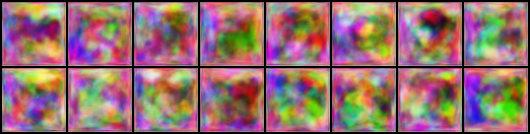

  0%|          | 1/6000 [00:03<6:28:22,  3.88s/it]

D losses = 7.22953732808431 G losses = -18.57452964782715


  4%|▍         | 250/6000 [07:53<3:02:06,  1.90s/it]

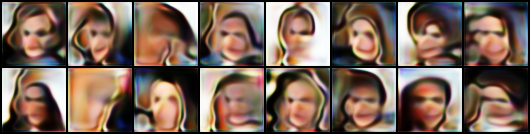

  4%|▍         | 251/6000 [07:56<3:13:20,  2.02s/it]

D losses = -4.8314820528030396 G losses = -47.618431091308594


  8%|▊         | 500/6000 [15:56<2:51:51,  1.87s/it]

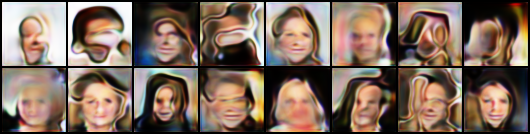

  8%|▊         | 501/6000 [15:58<2:58:12,  1.94s/it]

D losses = -5.410934925079346 G losses = -11.84927749633789


 12%|█▎        | 750/6000 [23:51<2:46:54,  1.91s/it]

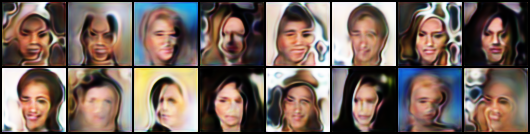

 13%|█▎        | 751/6000 [23:54<2:49:32,  1.94s/it]

D losses = -4.316572666168213 G losses = -27.355998992919922


KeyboardInterrupt: ignored

In [18]:
train(G,D,dataloader,optimizer_G,optimizer_D,n_dis=3,gp_scale=10,epochs=6000)

### The fourth task is to check model performance (3 pts)

1) Evaluate the FID metric for your model (3 pts)

Do not forget to use materials shared on seminars!

In [23]:
fid = FID(normalize=True).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 35.8MB/s]


In [24]:
for data in tqdm(dataloader):
    fid.update(data.to(device)/2+0.5,real=True)

100%|██████████| 3166/3166 [12:52<00:00,  4.10it/s]


In [26]:
#torch.save(fid,"drive/MyDrive/GAN/fid.pt")

In [27]:
N = 20000
for i in tqdm(range(N//batch_size)):
    fid.update(G(torch.randn(batch_size,128,device=device))/2+0.5,real=False)

100%|██████████| 312/312 [01:55<00:00,  2.71it/s]


In [28]:
fid.compute()

tensor(120.4909, device='cuda:0')

### The last task is to improve performance by correcting latent code sampling procedure (10 pts)

In this part you will implement I-SIR method to sample latent codes from corrected latent distribution and evaluate model performance with updated sampling using FID metric.

#### I-SIR (7 pts)

Algorithm:

* Sample $z \sim N(0,1)$ of shape $[N_s,1,n_z]$, where $n_z$ - size of latent space (128 for our model)

* FOR number of iterations $N_i$:
    * Sample additional particles $z_{\mathrm{add}} \sim N(0,1)$ of shape $[N_s,N_p,n_z]$
    * Concatenate $z$ with $z_{\mathrm{add}}$ along second dimension and reshape to the form $[-1,n_z]$. The result will be new $z$ of size $[N_s(N_p+1),n_z]$
    * Compute logarithm of density for new $z$ 
    
    $\log\rho(z) = -\frac{||z||_2^2}{2} + D(G(z))$ 
    
    and reshape result to the size $[N_s,N_p+1]$.
    * Make element-wise sampling from log density: fix first index and sample second one with respect to corresponding log density value (consider torch.distributions.Categorical). The result will be $idxs$ of size $[N_s]$.
    * Take particles according to sampled indexs $z = z[torch.arange(N_s),idxs]$.
* Return new samples $z$

#### Evaluate model using new sampling procedure (3 pts)

Compute FID metric by sampling latent code using I-SIR function. Leave a comment on obtained results.

In [2]:
def I_SIR(N_i,N_s,N_p,n_z,D,G,device):
  # your code is here
  z = torch.randn(N_s, 1, n_z).to(device) 
  for _ in range(N_i):
      z_add = torch.randn(N_s, N_p, n_z).to(device)
      z_new = torch.cat([z, z_add], dim=1).reshape(-1, n_z)
      lg = (-torch.norm(z_new, p=2, dim=1) ** 2 / 2 + D(G(z_new)).squeeze()).reshape(N_s, N_p+1)
      logits = torch.log_softmax(lg, dim=1) 
      idxs = dist.Categorical(logits=logits).sample()
      z = z_new.reshape(N_s, N_p+1, n_z)[torch.arange(N_s), idxs].unsqueeze(1)           
  return z.squeeze(1)

In [3]:
device = torch.device('cuda')
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64().to(device)
G.load_state_dict(torch.load('drive/MyDrive/GAN/G_750.pt'))
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64().to(device)
D.load_state_dict(torch.load('drive/MyDrive/GAN/D_750.pt'))

<All keys matched successfully>

In [4]:
fid = torch.load("drive/MyDrive/GAN/fid.pt").to(device)

In [5]:
N = 20000
batch_size=30
for i in tqdm(range(N//batch_size)):
    #torch.randn(batch_size,64,device=device)
    fid.update(G(I_SIR(5,batch_size,10,128,D,G,device))/2+0.5,real=False)

100%|██████████| 666/666 [44:29<00:00,  4.01s/it]


In [6]:
fid.compute()

tensor(141.8918, device='cuda:0')

In spite of the fact that GAN is undertrained (insidious colab), the results obtained are acceptable. Nevertheless, the fid obtained is noticeably high. It can be reduced by training the model with more epochs. Using I-SIR sampling increased the fid. I would suggest that this may be due to undertraining of the model.